In [ ]:
!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy gensim

## Load Data

In [ ]:
import preprocessing.preprocessing as pp
import numpy as np

In [ ]:
df = pp.load_data("english_cleaned_lyrics.csv")

## Preprocess: Choose Preprocessing

### Remove only punctuation and lower cases

In [ ]:
df = pp.preprocess_data(df, to_lower=True, remove_punct=True, remove_stops=False, lemmatize=False)

### Remove Stop Words

In [ ]:
df = pp.preprocess_data(df, to_lower=True, remove_punct=True, remove_stops=True, lemmatize=False)

### Remove stop words and lemmatization

In [ ]:
df = pp.preprocess_data(df, to_lower=True, remove_punct=True, remove_stops=True, lemmatize=True)

### Adjust distribution

In [ ]:
df = pp.adjust_genre_distribution(df)

In [ ]:
df = df[['lyrics', 'genre']]

In [ ]:
X = df['lyrics']
y = df['genre']

In [ ]:
import torch

## Embedding

In [ ]:
from gensim.models import KeyedVectors
from nltk import word_tokenize         

### Pretrained Word2Vec

In [ ]:
import gensim.downloader
pretrained_wv = gensim.downloader.load('glove-twitter-100')

### Custom Word2Vec

In [ ]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

## Training and test sets using Word2Vec

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Pretrained

In [ ]:
X_emb = np.array([document_vector(text, pretrained_wv) for text in X])

### Custom

In [202]:
X_emb = np.array([document_vector(text, wv) for text in X])

In [203]:
label_encoder = LabelEncoder()
classes = np.array(y.values)
integer_encoded = label_encoder.fit_transform(classes)

# Convert to PyTorch tensors
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)
X_tensor = torch.tensor(X_emb, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")
print(f"Features dimension: {y_train.shape}")

Features dimension: torch.Size([117148, 50])
Features dimension: torch.Size([117148])


### DataLoader

In [204]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Feed Forward neural network

In [205]:
#!pip install torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F

### Simple Model

In [206]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### More Complex Model

In [207]:
class MultiLayerPerceptronComplex(nn.Module):
    def __init__(self, vocab_size, num_class, hidden_size1, hidden_size2, hidden_size3):
        super(MultiLayerPerceptronComplex, self).__init__()
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(vocab_size, hidden_size1)  # dense layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # dense layer
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)  # dense layer
        self.fc4 = nn.Linear(hidden_size3, num_class)  # dense layer
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()
        self.fc3.weight.data.uniform_(-initrange, initrange)
        self.fc3.bias.data.zero_()
        self.fc4.weight.data.uniform_(-initrange, initrange)
        self.fc4.bias.data.zero_()


    def forward(self, text):
        h1 = self.fc1(text)
        a1 = self.activation(h1)
        h2 = self.fc2(a1)
        a2 = self.activation(h2)
        h3 = self.fc3(a2)
        a3 = self.activation(h3)
        h4 = self.fc4(a3)
        return h4

### Training simple Model

In [208]:
num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = MultiLayerPerceptron(vocab_size, 10, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

MultiLayerPerceptron(
  (fc1): Linear(in_features=50, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=6, bias=True)
)
Epoch [1/20], Loss: 1.6571
Precision: 0.5201, Recall: 0.5031, F1 Score: 0.4991
Epoch [2/20], Loss: 1.4035
Precision: 0.5296, Recall: 0.5108, F1 Score: 0.5139
Epoch [3/20], Loss: 0.8532
Precision: 0.5441, Recall: 0.5138, F1 Score: 0.5128
Epoch [4/20], Loss: 1.2281
Precision: 0.5398, Recall: 0.5153, F1 Score: 0.5172
Epoch [5/20], Loss: 1.4502
Precision: 0.5412, Recall: 0.5146, F1 Score: 0.5117
Epoch [6/20], Loss: 1.0607
Precision: 0.5347, Recall: 0.5139, F1 Score: 0.5072
Epoch [7/20], Loss: 1.2621
Precision: 0.5440, Recall: 0.5112, F1 Score: 0.5130
Epoch [8/20], Loss: 1.2715
Precision: 0.5383, Recall: 0.5156, F1 Score: 0.5128
Epoch [9/20], Loss: 1.2384
Precision: 0.5260, Recall: 0.5119, F1 Score: 0.5107
Epoch [10/20], Loss: 1.3968
Precision: 0.5333, Recall: 0.5109, F1 Score: 0.5126
Epoch [11/20], Loss: 1.5217
Precision: 0.5340, Recall: 0.5143, F1 

In [209]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [210]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.41      0.34      0.37      3110
           1       0.51      0.11      0.18      1504
           2       0.74      0.62      0.67      4239
           3       0.45      0.42      0.43      6747
           4       0.73      0.61      0.66      6689
           5       0.39      0.60      0.47      6999

    accuracy                           0.51     29288
   macro avg       0.54      0.45      0.46     29288
weighted avg       0.54      0.51      0.51     29288


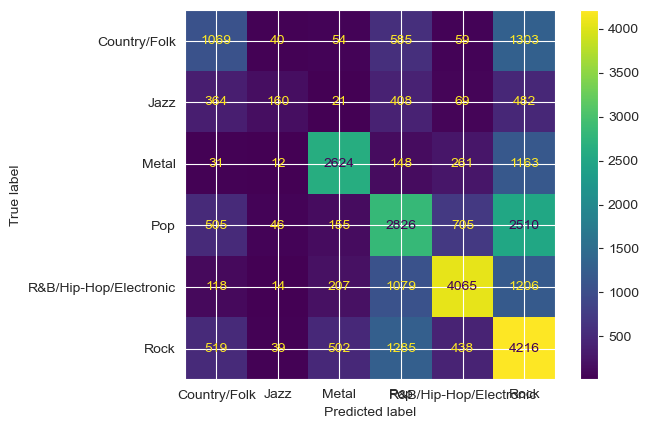

In [211]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()

### Training Complex model

In [212]:
num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = MultiLayerPerceptronComplex(vocab_size, num_classes, 64, 32, 16)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    all_labels = []
    all_predictions = []
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

MultiLayerPerceptronComplex(
  (activation): ReLU()
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=6, bias=True)
)
Epoch [1/20], Loss: 1.4676
Precision: 0.5100, Recall: 0.5098, F1 Score: 0.5002
Epoch [2/20], Loss: 1.4159
Precision: 0.5439, Recall: 0.5110, F1 Score: 0.5067
Epoch [3/20], Loss: 1.1838
Precision: 0.5534, Recall: 0.5149, F1 Score: 0.5168
Epoch [4/20], Loss: 1.5351
Precision: 0.5487, Recall: 0.5172, F1 Score: 0.5173
Epoch [5/20], Loss: 0.9694
Precision: 0.5535, Recall: 0.5261, F1 Score: 0.5282
Epoch [6/20], Loss: 1.1965
Precision: 0.5506, Recall: 0.5240, F1 Score: 0.5225
Epoch [7/20], Loss: 1.3112
Precision: 0.5592, Recall: 0.5231, F1 Score: 0.5258
Epoch [8/20], Loss: 1.4626
Precision: 0.5612, Recall: 0.5227, F1 Score: 0.5256
Epoch [9/20], Loss: 1.0071
Precision: 0.5458, Recall: 0.5233, F1 Score: 0.5

In [213]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.42      0.44      0.43      3110
           1       0.43      0.19      0.27      1504
           2       0.66      0.72      0.69      4239
           3       0.45      0.46      0.46      6747
           4       0.81      0.57      0.67      6689
           5       0.41      0.53      0.46      6999

    accuracy                           0.52     29288
   macro avg       0.53      0.49      0.50     29288
weighted avg       0.55      0.52      0.53     29288


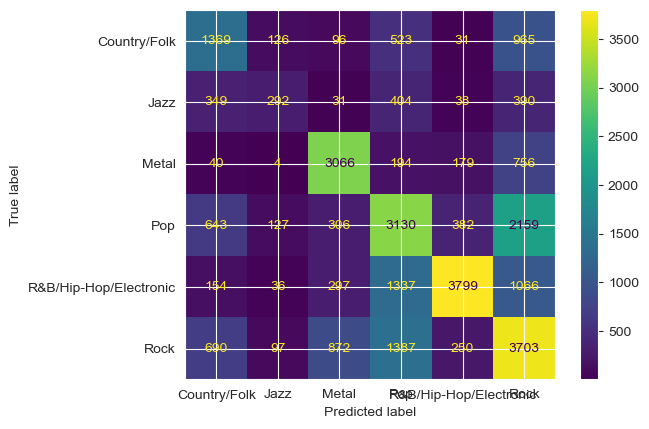

In [214]:
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()